In [1]:
!pip install ultralytics
!pip install xml.etree.ElementTree
!pip install pandas opencv-python matplotlib scikit-learn
!pip install sklearn
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from shutil import copyfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement xml.etree.ElementTree (from versions: none)
ERROR: No matching distribution found for xml.etree.ElementTree
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultral

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

def print_dataset_structure(root_dir: str, max_files_per_dir: int = 5) -> None:

    if not os.path.exists(root_dir):
        print(f"Error: Directory '{root_dir}' does not exist.")
        return

    print(f"Exploring dataset structure in: {root_dir}")
    print("------------------------------------------")

    total_files = 0
    total_dirs = 0

    for dirpath, dirnames, filenames in os.walk(root_dir):
        total_dirs += len(dirnames)
        total_files += len(filenames)

        print(f"\nDirectory: {dirpath}")
        print(f"  Subdirectories: {len(dirnames)} ({', '.join(dirnames) if dirnames else 'None'})")
        print(f"  Files: {len(filenames)}")

        # Print sample files with extensions
        if filenames:
            sample_files = filenames[:max_files_per_dir]
            print("  Sample files:")
            for file in sample_files:
                ext = os.path.splitext(file)[1]
                print(f"    - {file} (extension: {ext})")
            if len(filenames) > max_files_per_dir:
                print(f"    ... ({len(filenames) - max_files_per_dir} more files)")

    print("------------------------------------------")
    print(f"Summary: {total_dirs} subdirectories, {total_files} total files")

# Usage: Replace with your dataset path
root_dir = '/content/drive/MyDrive/archive'
print_dataset_structure(root_dir)


Exploring dataset structure in: /content/drive/MyDrive/archive
------------------------------------------

Directory: /content/drive/MyDrive/archive
  Subdirectories: 2 (test1, train)
  Files: 0

Directory: /content/drive/MyDrive/archive/test1
  Subdirectories: 1 (test)
  Files: 0

Directory: /content/drive/MyDrive/archive/test1/test
  Subdirectories: 0 (None)
  Files: 500
  Sample files:
    - Sabiha_(10)_jpg.rf.d163e2a53d5ed22112e9ead62807acf4.jpg (extension: .jpg)
    - Sabiha_(7)_jpg.rf.1c5a826117ba3cf7857a857c63df926a.jpg (extension: .jpg)
    - Sabiha_(21)_jpg.rf.9bcbc607d789a699bb41fa2ea9b80d85.jpg (extension: .jpg)
    - Sabiha_(24)_jpg.rf.66060ac19e1ebaf7aaebf7b638a17178.jpg (extension: .jpg)
    - Sabiha_(36)_jpg.rf.f432f0602c279655f3e0ed8b1157cef0.jpg (extension: .jpg)
    ... (495 more files)

Directory: /content/drive/MyDrive/archive/train
  Subdirectories: 1 (Final Train Dataset)
  Files: 0

Directory: /content/drive/MyDrive/archive/train/Final Train Dataset
  Subdirector

In [4]:
import shutil
# Input path to the mixed train folder
INPUT_TRAIN_DIR = '/content/drive/MyDrive/archive/train/Final Train Dataset'

# Working output paths for cleaned files
CLEAN_IMAGES_DIR = '/content/drive/MyDrive/working/cleaned_images'
CLEAN_ANNOTATIONS_DIR = '/content/drive/MyDrive/working/cleaned_annotations'

os.makedirs(CLEAN_IMAGES_DIR, exist_ok=True)
os.makedirs(CLEAN_ANNOTATIONS_DIR, exist_ok=True)

def clean_xml_file(xml_path: str, img_path: str) -> bool:

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get image size from XML
        size = root.find('size')
        if size is None:
            return False
        img_width = int(size.find('width').text)
        img_height = int(size.find('height').text)

        # Validate each object
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            if bbox is None:
                return False
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # Check logical bounds
            if xmin >= xmax or ymin >= ymax or xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False  # Invalid box, skip this file

        return True  # All checks passed
    except (ET.ParseError, ValueError):
        return False  # Parsing error or invalid values

# Get all files from input train dir
all_files = os.listdir(INPUT_TRAIN_DIR)
annotation_files = [f for f in all_files if f.lower().endswith('.xml')]

valid_count = 0
skipped_files = []  # To log invalid/skipped XMLs

for ann_file in annotation_files:
    xml_path = os.path.join(INPUT_TRAIN_DIR, ann_file)
    base_name = os.path.splitext(ann_file)[0].lower()  # Case-insensitive base name
    # Find matching image (assume .jpg, but check for .JPG or other cases)
    possible_img_files = [f for f in all_files if f.lower().startswith(base_name) and f.lower().endswith('.jpg')]
    if not possible_img_files:
        skipped_files.append(ann_file)  # No matching image
        continue
    img_file = possible_img_files[0]  # Take the first match
    img_path = os.path.join(INPUT_TRAIN_DIR, img_file)

    # Validate XML
    if clean_xml_file(xml_path, img_path):
        # Copy valid pair
        shutil.copy(xml_path, os.path.join(CLEAN_ANNOTATIONS_DIR, ann_file))
        shutil.copy(img_path, os.path.join(CLEAN_IMAGES_DIR, img_file))
        valid_count += 1
    else:
        skipped_files.append(ann_file)  # Invalid XML

# Final cleanup: Remove any unpaired files in cleaned dirs
clean_image_bases = {os.path.splitext(f)[0].lower() for f in os.listdir(CLEAN_IMAGES_DIR)}
clean_ann_bases = {os.path.splitext(f)[0].lower() for f in os.listdir(CLEAN_ANNOTATIONS_DIR)}

for img in list(os.listdir(CLEAN_IMAGES_DIR)):
    if os.path.splitext(img)[0].lower() not in clean_ann_bases:
        os.remove(os.path.join(CLEAN_IMAGES_DIR, img))

for ann in list(os.listdir(CLEAN_ANNOTATIONS_DIR)):
    if os.path.splitext(ann)[0].lower() not in clean_image_bases:
        os.remove(os.path.join(CLEAN_ANNOTATIONS_DIR, ann))

# Print results
print(f"Cleaned and matched images: {len(os.listdir(CLEAN_IMAGES_DIR))}")
print(f"Cleaned and matched annotations: {len(os.listdir(CLEAN_ANNOTATIONS_DIR))}")
print(f"Total valid pairs: {valid_count}")
if skipped_files:
    print(f"Skipped {len(skipped_files)} invalid or unmatched XML files (first 5): {skipped_files[:5]}")
else:
    print("No files skipped.")


Cleaned and matched images: 2909
Cleaned and matched annotations: 2909
Total valid pairs: 2986
Skipped 17 invalid or unmatched XML files (first 5): ['Pias (359).xml', 'Pias (360).xml', '193.xml', '200.xml', '205.xml']


In [5]:
# Use the cleaned directories from previous step
CLEAN_IMAGES_DIR = '/content/drive/MyDrive/working/cleaned_images'
CLEAN_ANNOTATIONS_DIR = '/content/drive/MyDrive/working/cleaned_annotations'

def parse_xml(xml_path: str) -> list:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find('filename').text
    objects = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({'filename': filename, 'class': label, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})
    return objects

# Collect all data
all_xml = [os.path.join(CLEAN_ANNOTATIONS_DIR, f) for f in os.listdir(CLEAN_ANNOTATIONS_DIR) if f.endswith('.xml')]
dataset = []
for xml_file in all_xml:
    objects = parse_xml(xml_file)
    dataset.extend(objects)

df = pd.DataFrame(dataset)

# Add bbox dimensions for visualization
df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']
df['area'] = df['width'] * df['height']

print(f"DataFrame shape: {df.shape}")
print(df.head())


DataFrame shape: (23392, 9)
         filename    class  xmin  ymin  xmax  ymax  width  height    area
0  Dipto_ 113.jpg    truck   997   223  1681   707    684     484  331056
1  Dipto_ 113.jpg      car   891   509   981   577     90      68    6120
2  Dipto_ 113.jpg      car   773   511   801   533     28      22     616
3  Dipto_ 113.jpg  minivan   841   501   894   538     53      37    1961
4  Dipto_ 113.jpg    truck   881   476   934   509     53      33    1749


In [6]:
# Print unique classes and counts
class_counts = df['class'].value_counts()
print("Unique classes and counts:\n", class_counts)

# Select 3-4 classes (adjust based on output; example assumes common ones)
selected_classes = ['car', 'bus', 'motorcycle', 'truck']  # Replace with actual top classes from print
df_filtered = df[df['class'].isin(selected_classes)]

if df_filtered.empty:
    print("Warning: Selected classes not found. Adjust based on unique classes above.")
else:
    print(f"Filtered DataFrame shape: {df_filtered.shape}")


Unique classes and counts:
 class
car                     5333
bus                     3212
rickshaw                3210
three wheelers (CNG)    2890
motorbike               2232
truck                   1476
pickup                  1193
minivan                  907
suv                      829
van                      733
bicycle                  439
auto rickshaw            372
human hauler             163
wheelbarrow              109
ambulance                 68
taxi                      59
minibus                   52
army vehicle              43
scooter                   37
policecar                 32
garbagevan                 3
Name: count, dtype: int64
Filtered DataFrame shape: (10021, 9)


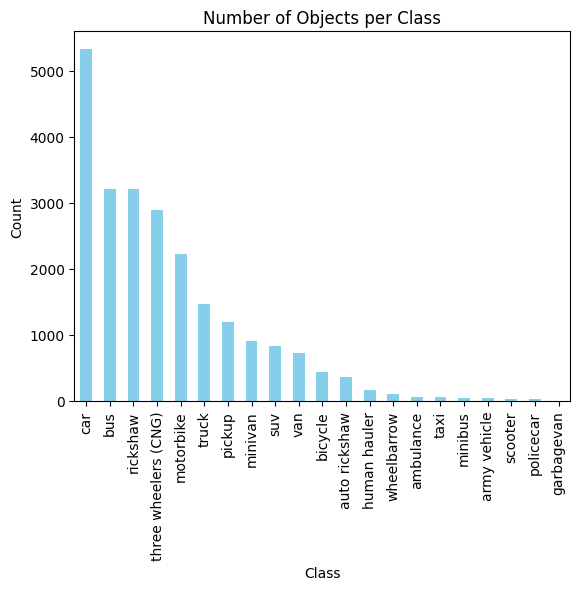

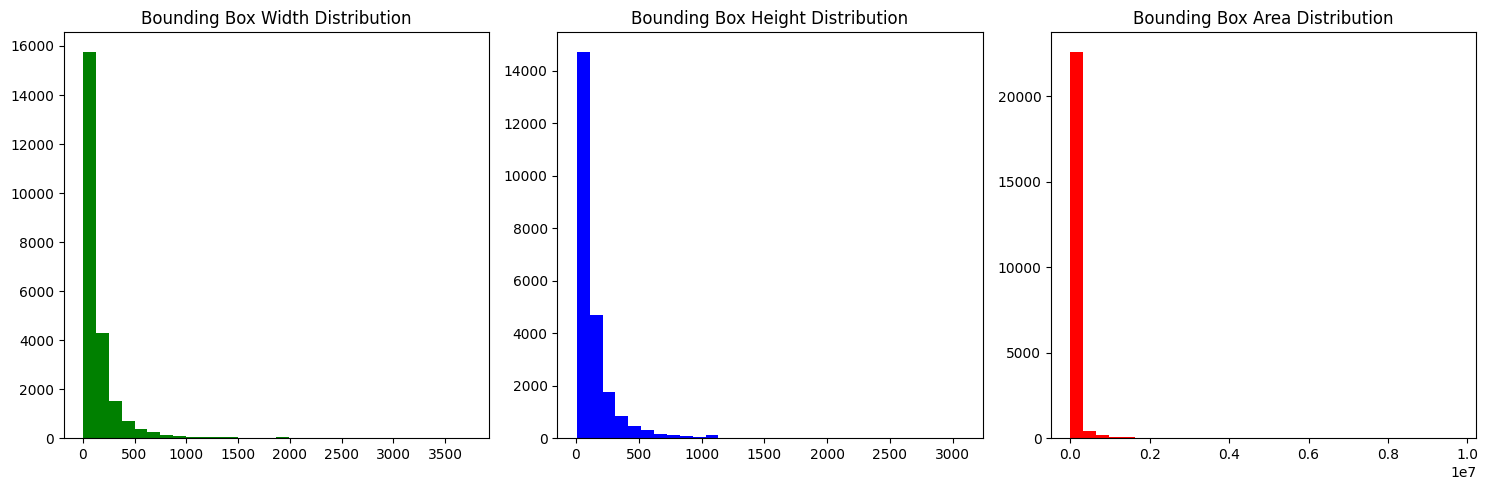

In [7]:
import matplotlib.pyplot as plt

if not df.empty:
    # Class distribution
    df['class'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Number of Objects per Class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    # Bounding box width, height, and area distributions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(df['width'], bins=30, color='green')
    axs[0].set_title('Bounding Box Width Distribution')
    axs[1].hist(df['height'], bins=30, color='blue')
    axs[1].set_title('Bounding Box Height Distribution')
    axs[2].hist(df['area'], bins=30, color='red')
    axs[2].set_title('Bounding Box Area Distribution')
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize.")


In [8]:
from sklearn.model_selection import train_test_split
# Use cleaned directories and filtered df from previous steps
CLEAN_IMAGES_DIR = '/content/drive/MyDrive/working/cleaned_images'
TRAIN_DIR = '/content/drive/MyDrive/working/train'
VAL_DIR = '/content/drive/MyDrive/working/val'

# Update selected classes to match exact names (based on your output)
selected_classes = ['car', 'bus', 'motorbike', 'truck']
class_to_id = {cls: idx for idx, cls in enumerate(selected_classes)}

# Filter df again with corrected classes
df_filtered = df[df['class'].isin(selected_classes)]
print(f"Updated filtered DataFrame shape: {df_filtered.shape}")

# Create train/val directories
for split in ['train', 'val']:
    os.makedirs(os.path.join('/content/drive/MyDrive/working', split, 'images'), exist_ok=True)
    os.makedirs(os.path.join('/content/drive/MyDrive/working', split, 'labels'), exist_ok=True)

# Group by filename and split (stratified by class for balance)
unique_files = df_filtered['filename'].unique()
stratify_labels = df_filtered.groupby('filename')['class'].apply(lambda x: x.mode()[0] if not x.empty else None)
train_files, val_files = train_test_split(unique_files, test_size=0.2, stratify=stratify_labels, random_state=42)

# Convert to YOLO format and copy files
for filename in unique_files:
    group = df_filtered[df_filtered['filename'] == filename]
    if group.empty:
        continue

    img_path = os.path.join(CLEAN_IMAGES_DIR, filename)
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    label_lines = []
    for _, row in group.iterrows():
        cls_id = class_to_id[row['class']]
        cx = (row['xmin'] + row['xmax']) / 2.0 / w
        cy = (row['ymin'] + row['ymax']) / 2.0 / h
        bw = (row['xmax'] - row['xmin']) / w
        bh = (row['ymax'] - row['ymin']) / h
        label_lines.append(f"{cls_id} {cx} {cy} {bw} {bh}")

    split = 'train' if filename in train_files else 'val'
    split_images_dir = os.path.join('/content/drive/MyDrivee/working', split, 'images')
    split_labels_dir = os.path.join('/content/drive/MyDrive/working', split, 'labels')

    shutil.copy(img_path, os.path.join(split_images_dir, filename))
    label_path = os.path.join(split_labels_dir, filename.replace('.jpg', '.txt'))
    with open(label_path, 'w') as f:
        f.write('\n'.join(label_lines))

print(f"Train images: {len(os.listdir(os.path.join('/content/drive/MyDrive/working/train/images')))}")
print(f"Val images: {len(os.listdir(os.path.join('/content/drive/MyDrive/working/val/images')))}")

# Create dataset.yaml
yaml_content = f"""
path: /content/drive/MyDrive/working
train: train/images
val: val/images

nc: {len(selected_classes)}
names: {selected_classes}
"""
with open('/content/drive/MyDrivee/working/dataset.yaml', 'w') as f:
    f.write(yaml_content)

Updated filtered DataFrame shape: (12253, 9)
Train images: 1978
Val images: 498


In [9]:
from ultralytics import YOLO

model = YOLO('yolov8l.pt')  # Larger model for better accuracy
# Train with optimizations
results = model.train(
    data='/content/drive/MyDrive/working/dataset.yaml',
    epochs=10,  # Increased for better convergence
    imgsz=640,
    batch=16,  # Adjust based on GPU memory
    augment=True,  # Built-in augmentations
    patience=20,  # Early stopping
    lr0=0.001,  # Lower learning rate
    optimizer='AdamW',
    cos_lr=True,  # Cosine scheduler
    weight_decay=0.0005,
    label_smoothing=0.1,  # Smooth labels
    hsv_h=0.02, hsv_s=0.7, hsv_v=0.4,  # Color augmentations
    degrees=15, translate=0.2, scale=0.6, shear=10,  # Geometric augmentations
    mixup=0.5,  # Mixup for better generalization
    device=0  # GPU
)


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=15, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.5, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Ad

In [10]:
metrics = model.val()
print(f"mAP@0.5: {metrics.box.map50}")
print(f"Precision: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2631.2±747.6 MB/s, size: 158.8 KB)
val: Scanning /kaggle/working/val/labels.cache... 472 images, 26 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 498/498 616.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.0it/s 31.2s
                   all        498       1976      0.696       0.57      0.607      0.328
                   car        269        784      0.685      0.644      0.661      0.394
                   bus        268        542      0.694      0.555       0.61      0.353
             motorbike        187        343      0.707      0.479      0.515      0.202
                 truck        156        307      0.699      0.603      0.643      0.363
Speed: 0.9ms preprocess, 56.0ms inference, 0

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1988.3±136.4 MB/s, size: 170.6 KB)
val: Scanning /content/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000 6.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 313/313 2.0it/s 2:34
                   all       5000      36335       0.74      0.634      0.695      0.531
                person       2693      10777      0.826      0.762      0.846      0.641
               bicycle        149        314      0.782      0.557       0.67      0.427
                   car        535       1918      0.781      0.673      0.748       0.53
            motorcycle        159        367      0.786       0.73      0.804      0.568
              airplane         97        143      0.889      0.888      0.933      0.789
                   bus    

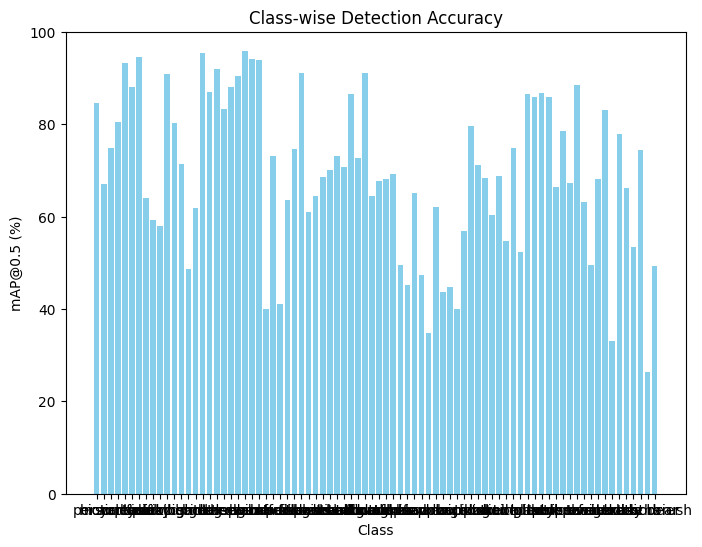

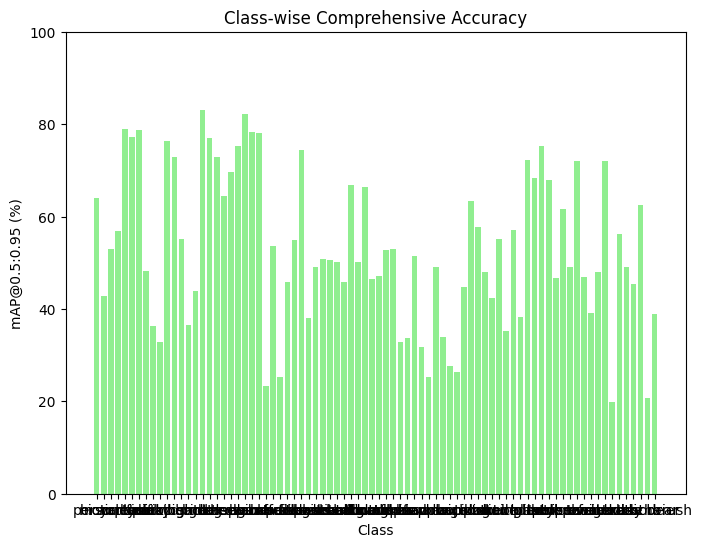

Overall mAP@0.5: 0.6947
Overall mAP@0.5:0.95: 0.5305
Mean Precision: 0.7396
Mean Recall: 0.6340
Mean F1 Score: 0.6828
Training history not available to plot accuracy/loss curves.


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Validation metrics ---
metrics = model.val()

# --- Class-wise metrics ---
classes = [metrics.names[i] for i in range(len(metrics.names))]
nc = len(classes)

def safe_metric(metric_array, n):
    if metric_array is None:
        return [0.0] * n
    result = []
    for x in metric_array:
        try:
            result.append(float(x))
            except:
            result.append(0.0)
    if len(result) < n:
        result += [0.0] * (n - len(result))
    elif len(result) > n:
        result = result[:n]
    return result

precision = safe_metric(metrics.box.p, nc)
recall    = safe_metric(metrics.box.r, nc)
map50     = safe_metric(metrics.box.ap50, nc)
map5095   = safe_metric(metrics.box.ap, nc)

# --- Build DataFrame ---
metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision (%)': [p*100 for p in precision],
    'Recall (%)': [r*100 for r in recall],
    'mAP@0.5 (%)': [m*100 for m in map50],
    'mAP@0.5:0.95 (%)': [m*100 for m in map5095]
})
print(metrics_df)

# --- Confusion Matrix ---
tp, confs, pred_classes, target_classes, target_images = metrics.stats

def flatten_numeric(lst):
    flat = []
    for sub in lst:
        # If sub is iterable, iterate over it; else wrap in list
        if isinstance(sub, (list, np.ndarray)):
            items = sub
        else:
            items = [sub]
        for x in items:
            try:
                flat.append(int(x))
            except:
                continue  # skip non-integer values
    return flat

flat_pred = flatten_numeric(pred_classes)
flat_true = flatten_numeric(target_classes)

# Define the target classes for the confusion matrix
target_cm_classes = ['car', 'rickshaw', 'bus', 'three wheelers (CNG)']
target_cm_ids = [classes.index(cls) for cls in target_cm_classes if cls in classes]

if len(flat_pred) == len(flat_true) and len(flat_pred) > 0:
    # Create a mapping for the new confusion matrix labels
    old_to_new_id = {old_id: new_id for new_id, old_id in enumerate(target_cm_ids)}
    new_flat_pred = [old_to_new_id.get(x, -1) for x in flat_pred] # Map to new IDs, use -1 for other classes
    new_flat_true = [old_to_new_id.get(x, -1) for x in flat_true]

    # Filter out the -1 entries (classes not in target_cm_classes)
    filtered_new_pred = [new_flat_pred[i] for i in range(len(new_flat_pred)) if new_flat_true[i] != -1 and new_flat_pred[i] != -1]
    filtered_new_true = [new_flat_true[i] for i in range(len(new_flat_true)) if new_flat_true[i] != -1 and new_flat_pred[i] != -1]


    if len(filtered_new_pred) > 0:
        cm = confusion_matrix(filtered_new_true, filtered_new_pred, labels=list(range(len(target_cm_ids))))
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_cm_classes, yticklabels=target_cm_classes)
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title(f'Confusion Matrix for {", ".join(target_cm_classes)}')
        plt.show()
    else:
         print("No instances of target classes found in predictions or true labels for confusion matrix.")

else:
    print(f"Inconsistent lengths or empty after cleaning: pred={len(flat_pred)}, true={len(flat_true)}")


# --- Class-wise mAP Bar Charts ---
plt.figure(figsize=(8,6))
plt.bar(classes, [m*100 for m in map50], color='skyblue')
plt.xlabel('Class')
plt.ylabel('mAP@0.5 (%)')
plt.title('Class-wise Detection Accuracy')
plt.ylim(0, 100)
plt.show()

plt.figure(figsize=(8,6))
plt.bar(classes, [m*100 for m in map5095], color='lightgreen')
plt.xlabel('Class')
plt.ylabel('mAP@0.5:0.95 (%)')
plt.title('Class-wise Comprehensive Accuracy')
plt.ylim(0, 100)
plt.show()

# --- Overall Metrics ---
mean_p = float(metrics.box.mp) if metrics.box.mp is not None else 0.0
mean_r = float(metrics.box.mr) if metrics.box.mr is not None else 0.0
f1 = 2 * mean_p * mean_r / (mean_p + mean_r + 1e-16)
print(f"Overall mAP@0.5: {float(metrics.box.map50):.4f}")
print(f"Overall mAP@0.5:0.95: {float(metrics.box.map):.4f}")
print(f"Mean Precision: {mean_p:.4f}")
print(f"Mean Recall: {mean_r:.4f}")
print(f"Mean F1 Score: {f1:.4f}")

# --- Plotting Training and Validation Accuracy ---
if results and hasattr(results, 'history'):
    history = results.history
    epochs = range(1, len(history['train/box_loss']) + 1) # Assuming all history lists have the same length

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train/box_loss'], label='Training Box Loss')
    plt.plot(epochs, history['val/box_loss'], label='Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Box Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train/cls_loss'], label='Training Class Loss')
    plt.plot(epochs, history['val/cls_loss'], label='Validation Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Class Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['metrics/mAP50(B)'], label='Validation mAP@0.5')
    plt.plot(epochs, history['metrics/mAP50-95(B)'], label='Validation mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Validation mAP over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Training history not available to plot accuracy/loss curves.")


0: 640x640 1 car, 40.8ms
1: 640x640 7 persons, 1 bicycle, 2 buss, 40.8ms
2: 640x640 5 cars, 40.8ms
3: 640x640 4 cars, 1 bus, 1 truck, 40.8ms
4: 640x640 3 persons, 8 cars, 3 buss, 40.8ms
5: 640x640 9 persons, 6 bicycles, 1 car, 1 stop sign, 40.8ms
6: 640x640 1 person, 1 car, 1 truck, 40.8ms
7: 640x640 2 persons, 1 car, 40.8ms
8: 640x640 3 cars, 2 buss, 1 truck, 40.8ms
9: 640x640 4 persons, 1 bicycle, 2 cars, 1 motorcycle, 1 truck, 40.8ms
Speed: 4.9ms preprocess, 40.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


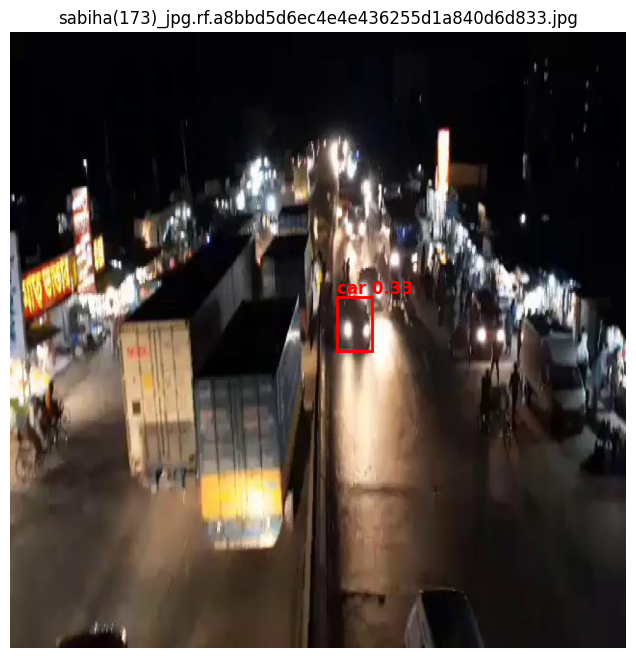

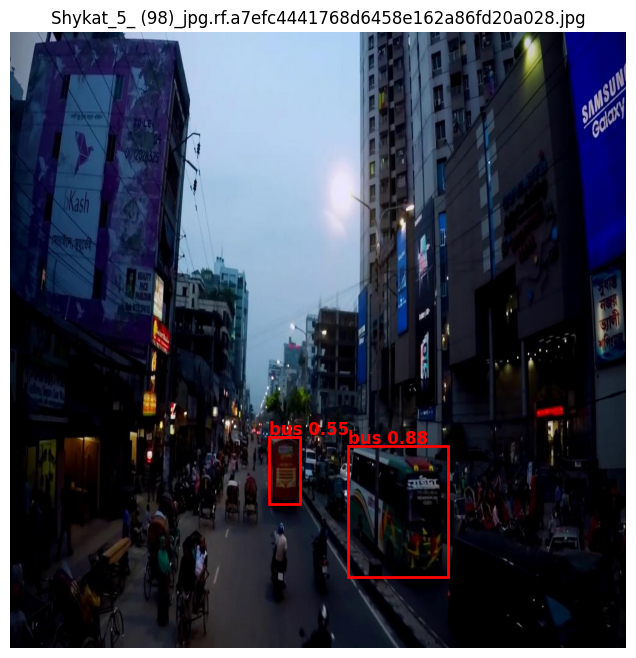

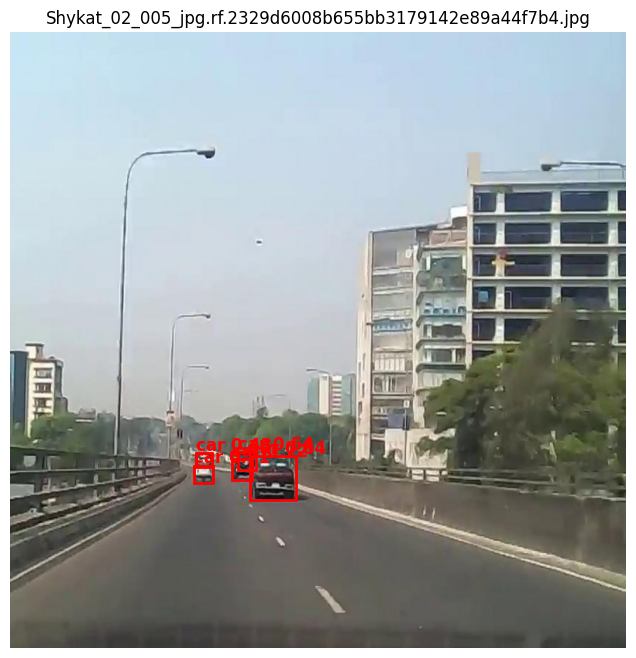

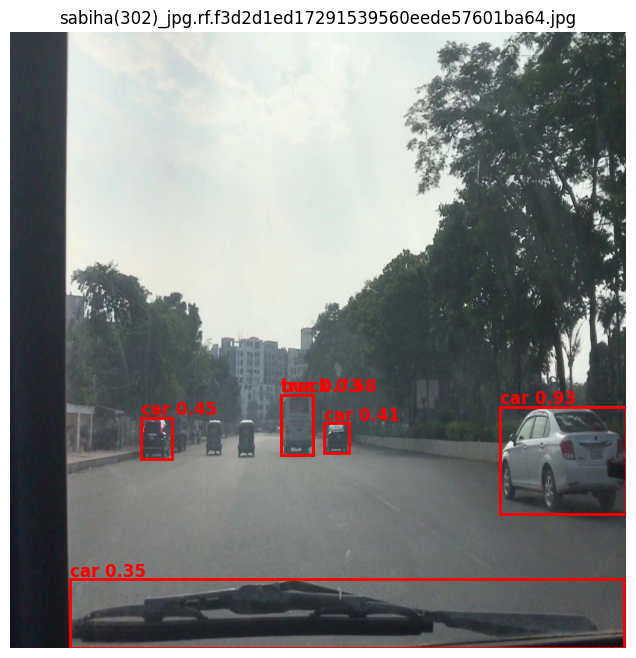

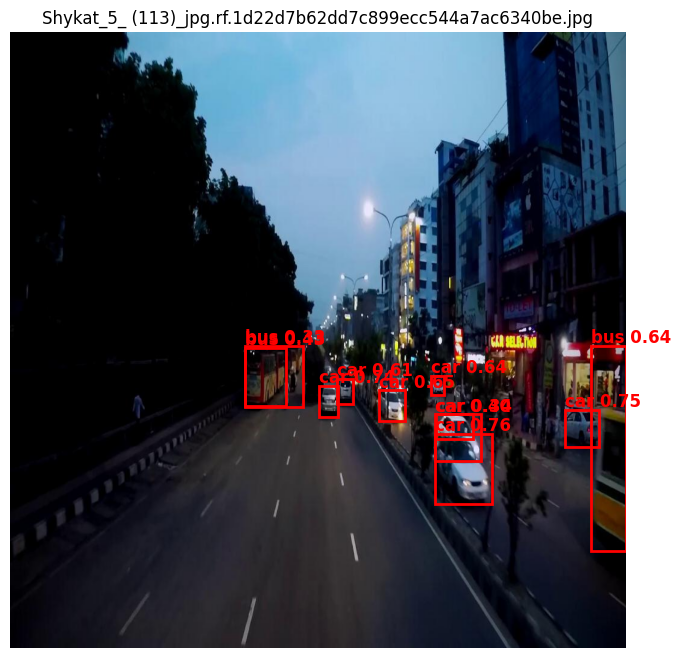

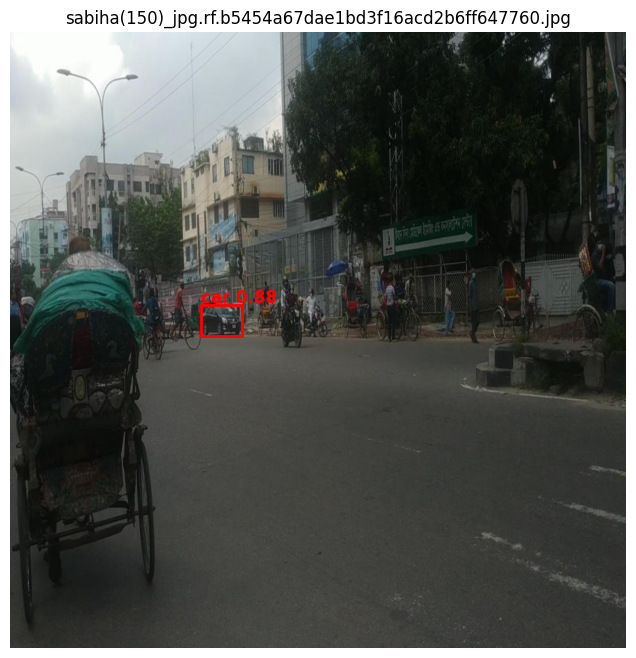

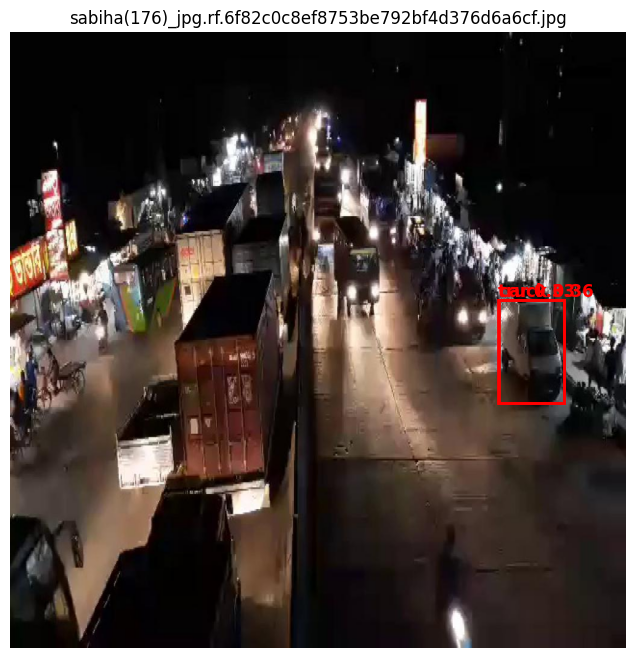

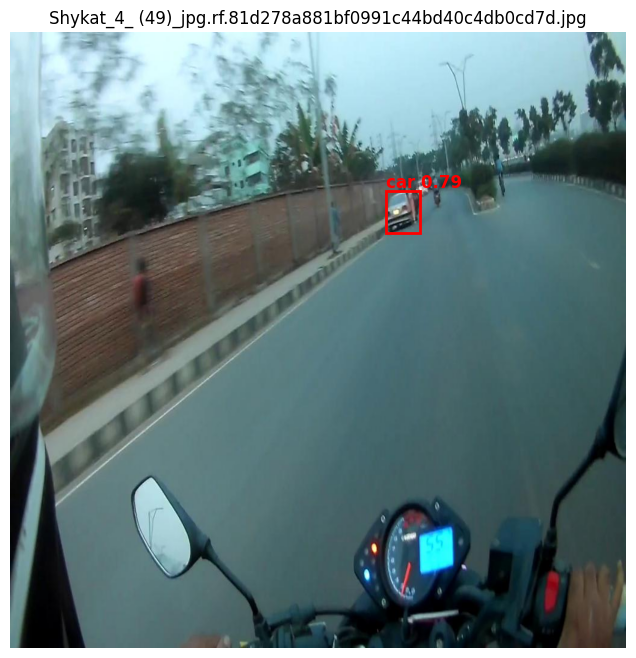

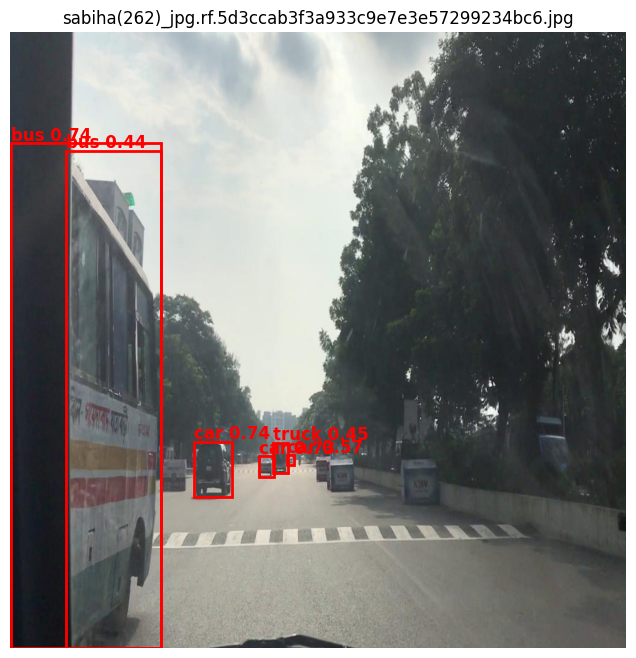

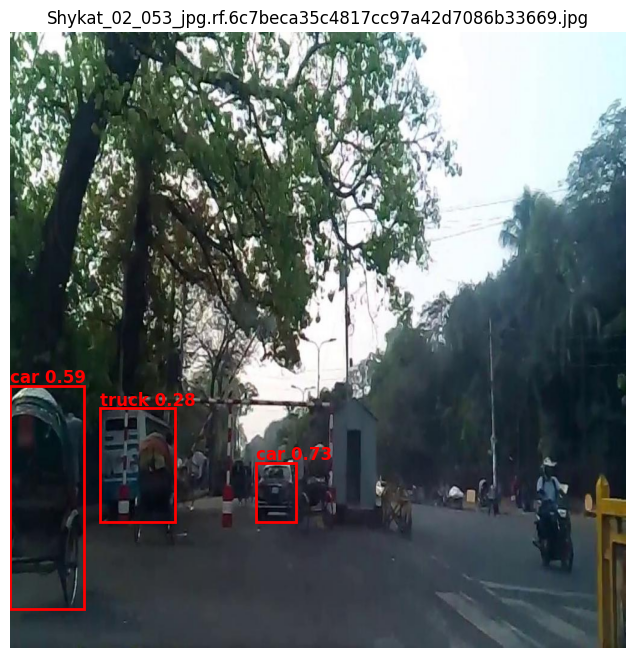

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# --- Load YOLOv8 model ---
model_path = '/content/drive/MyDrive/working/yolov8l.pt'  # adjust path
model = YOLO(model_path)

# --- Define the classes you want to display ---
target_classes = ['car', 'bus', 'motorbike', 'truck']

# --- Select 10 random images from the test folder ---
test_dir = '/content/drive/MyDrive/archive/test1/test'
all_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]
random_images = random.sample(all_images, 10)

# --- Run predictions ---
results = model.predict(source=random_images, save=False)

# --- Display images with only target class detections ---
for img_path, res in zip(random_images, results):
    img = Image.open(img_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))

    if res.boxes is not None and len(res.boxes) > 0:
        for box, cls, conf in zip(res.boxes.xyxy.cpu().numpy(),
                                  res.boxes.cls.cpu().numpy(),
                                  res.boxes.conf.cpu().numpy()):
            cls_name = model.names[int(cls)]
            if cls_name in target_classes:
                x1, y1, x2, y2 = box
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                  edgecolor='red', facecolor='none', linewidth=2))
                plt.text(x1, y1-5, f'{cls_name} {conf:.2f}', color='red', fontsize=12, weight='bold')
    plt.show()
